In [1]:
import numpy as np
import scipy as sp
import torch as th

import os, pdb, sys, json, glob, tqdm
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('whitegrid')

sns.set_context('notebook')

# %matplotlib notebook
plt.rcParams['figure.figsize'] = [10, 10]
plt.rcParams['figure.dpi'] = 200
sns.set(context='poster',
        style='ticks',
        font_scale=1,
        rc={'axes.grid':True,
            'grid.color':'.9',
            'grid.linewidth':0.75})
%load_ext autoreload
%autoreload 2

dev = 'cuda'
root = '/home/ubuntu/ext_vol'
import sys
sys.path.insert(0, f'{root}/inpca')

from utils import get_data, get_idx

In [2]:
sns.plotting_context("poster")

{'axes.linewidth': 2.5,
 'grid.linewidth': 2,
 'lines.linewidth': 3.0,
 'lines.markersize': 12,
 'patch.linewidth': 2,
 'xtick.major.width': 2.5,
 'ytick.major.width': 2.5,
 'xtick.minor.width': 2,
 'ytick.minor.width': 2,
 'xtick.major.size': 12,
 'ytick.major.size': 12,
 'xtick.minor.size': 8,
 'ytick.minor.size': 8,
 'font.size': 24,
 'axes.labelsize': 24,
 'axes.titlesize': 24,
 'xtick.labelsize': 22,
 'ytick.labelsize': 22,
 'legend.fontsize': 22,
 'legend.title_fontsize': 24}

In [3]:
import plotly.graph_objects as go
import numpy as np
import plotly.offline as pyo
import pandas as pd
pyo.init_notebook_mode()

## Plotly

In [4]:
from matplotlib.gridspec import GridSpec
def triplot(dc, r, d=3, emph=[], cmap='vlag', ckey='', skey='',
            markers=["o", "x", "s", "*", "+"], evals=False,
            grid_size=0.25, grid_ratio=[5, 3, 2], legend=False,
            centers=[0,0,0]):

    widths = grid_ratio[1:]
    heights = grid_ratio[:-1]
    fig = plt.figure(figsize=(8*sum(widths)/sum(heights), 8))
    gs = GridSpec(d-1, d-1, width_ratios=widths, height_ratios=heights)

    if len(emph) > 0:
        iie = []
        for ie in emph:
            iie.extend(ie)
        d_ = dc.drop(iie)
        xx = r['xp'][d_.index, :]
        d_ = d_.reset_index(drop=True)
    else:
        d_ = dc
        xx = r['xp']
    
    ee = r['e']
    c = d_[ckey]
    if skey:
        s = d_[skey]
    else:
        s = 2
        
    if len(c.unique()) < 10:
        cdict = {c:i for (i, c) in enumerate(c.unique())}
        c = c.map(cdict) 
        print(cdict)

    for d1 in range(d-1):
        for d2 in range(d1+1, d):

            ax = fig.add_subplot(gs[d1, d2-1])
            
            sc = ax.scatter(xx[:, d2], xx[:, d1],
                            c=c, cmap=cmap, vmin=c.min(), vmax=c.max(), s=s, lw=0.5, alpha=0.5)
            if len(emph) > 0:
                sc_emph = ax.scatter(r['xp'][emph, d2], r['xp'][emph, d1],
                            c='red', s=s+10, lw=0.5, alpha=0.5)
            ax.set_xlim([centers[d2]-grid_size*grid_ratio[d2], centers[d2]+grid_size*grid_ratio[d2]])
            ax.set_ylim([centers[d1]-grid_size*grid_ratio[d1], centers[d1]+grid_size*grid_ratio[d1]])
            
            if ee[d2] < 0:
                ax.spines['bottom'].set_color('red')
            if ee[d1] < 0:
                ax.spines['left'].set_color('red')
            
            if d2 == d1+1:
                ax.set_xlabel(f'pc{d2+1}')
                ax.set_ylabel(f'pc{d1+1}')
                ax.grid(False)
            else:
                ax.set_xticks([])
                ax.set_yticks([])

    if legend:
        ax = fig.add_subplot(gs[-1, 0])
        ax.set_visible(False)
        clb = plt.colorbar(sc, pad=0.2, ax=ax)
        clb.ax.set_title(ckey)
#         ax.legend(handles, labels, loc='lower center')
#     plt.tight_layout()
    plt.subplots_adjust(wspace=0., hspace=0.)
    
    plt.show()
    return fig, gs

In [5]:
from bokeh import palettes
def plotly_3d(dc, r, emph=[], empcolor={}, empsize={}, empmode='markers',
              return_d=False, ne=3, dims=[1, 2, 3],
              color='t', colorscale='RdBu', mode='markers',
              xrange=[-1, 1], yrange=[-1, 1], zrange=[-1, 1], opacity=0.7):
    
    for (config, idxs) in dc.groupby(['m', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
        tmax = dc.iloc[idxs]['t'].max()
        dc.loc[idxs, 't'] /= tmax
    for i in range(ne):
        dc[f"x{i+1}"] = r['xp'][:, i]
    
    c = dc[color]
    discrete_c = len(c.unique()) < 10
    if discrete_c:
        colors = getattr(palettes, colorscale)[max(len(c.unique()), 3)]
        cdict = {c:colors[i] for (i, c) in enumerate(c.unique())}
    
    size = 2 * np.ones(len(dc))
    
    fig = go.Figure()
    
    if len(emph) > 0:
        iie = []
        for (_, ie) in emph.items():
            iie.extend(ie)
        d_ = dc.drop(iie).reset_index(drop=True)
    else:
        d_ = dc

        
    if discrete_c:
        for c_ in c.unique():
            ii = d_[d_[color]==c_].index
            di = d_.iloc[ii]
            ci = d_[color].iloc[ii]

            fig.add_trace(
                go.Scatter3d(
                    x=di[f'x{dims[0]}'],  
                    y=di[f'x{dims[1]}'],  
                    z=di[f'x{dims[2]}'],  
                    marker=dict(
                        size=2,
                        opacity=opacity,
                        color=ci.map(cdict),
                    ),
                    mode='markers',
                    name=c_,
                    showlegend=True
                )
            )
    else:
        fig.add_trace(
            go.Scatter3d(
                    x=d_[f'x{dims[0]}'],  
                    y=d_[f'x{dims[1]}'],  
                    z=d_[f'x{dims[2]}'],  
                    marker=dict(
                        size=2,
                        opacity=opacity,
                        color=c,
                        colorscale=colorscale
                    ),
                    mode='markers',
                    showlegend=False
                )
        )
            
    if len(emph) > 0:
        for (name, ie) in emph.items():
            demph = dc.iloc[ie]
            iie.extend(ie)
            fig.add_trace(
            go.Scatter3d(
                x=demph[f'x{dims[0]}'],  
                y=demph[f'x{dims[1]}'],  
                z=demph[f'x{dims[2]}'],  
                marker=dict(
                    size=empsize.get(name, 4),
                    opacity=0.9,
                    color=empcolor.get(name, 'darkred'),
                ),
                mode=empmode,
                name=name,
                showlegend=True
                )
            )
    axis_color = ['red' if r['e'][i] < 0 else 'black' for i in range(3)]
    fig.update_layout(
        autosize=False,
        width=1000,
        height=1000,
        scene_xaxis_range=xrange,
        scene_yaxis_range=yrange,
        scene_zaxis_range=zrange,
        template='plotly_white',
        scene_xaxis_linecolor=axis_color[0],
        scene_xaxis_linewidth=4.5,        
        scene_yaxis_linecolor=axis_color[1],
        scene_yaxis_linewidth=4.5,
        scene_zaxis_linecolor=axis_color[2],
        scene_zaxis_linewidth=4.5,
        scene_aspectratio={
            'x':xrange[1]-xrange[0],
            'y':yrange[1]-yrange[0],
            'z':zrange[1]-zrange[0],
        },
        legend=dict(itemsizing="constant", 
                    itemwidth=100,
                    yanchor="top",
                    y=0.99,
                    xanchor="left",
                    x=0.01)
    )
    print(r['e'])

    return fig

#### Train with Geod (included in embedding)

In [91]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [57]:
ii = np.argsort(r['es'])[::-1]
es = r['es'][ii]
vs = r['vs'][:, ii]
b = r['diag']
tr = r['tr']

df = []
for i in range(len(es)):
    tr = 2*(r['tr'] - es[:i].sum())**2
    bnorm = 2*len(vs)*((b - (es[:i]*(vs[:, :i]**2)).sum(1))**2).sum()
    Bf = 4*(r['fn']**2 - (es[:i]**2).sum())
    df.append(tr+bnorm+Bf)

In [93]:
idxs = []
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
    if didx.iloc[ii[-1]]['err'] < 0.1:
        idxs.extend(ii)
didx = didx.iloc[idxs].reset_index(drop=True)
r['xp'] = r['xp'][idxs, :]

In [9]:
u = np.linspace(0, 5, 240)
v = np.linspace(0, 2 * np.pi, 240)
uGrid, vGrid = np.meshgrid(u, v)

x = uGrid * np.cos(vGrid) + p[0]
y = uGrid + p[1]
z = uGrid * np.sin(vGrid) + p[2]

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
cmap = {f"m: {c}": i for (i, c) in enumerate(didx.m.unique())} 
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':4, 'p0':8, 'p*':8}, 
                    empcolor={'geodesic':'darkred', 'p0':'red', 'p*':'red'},
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='m',mode='markers', 
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [46]:
fig.write_image("plots/all_models_3d.pdf")

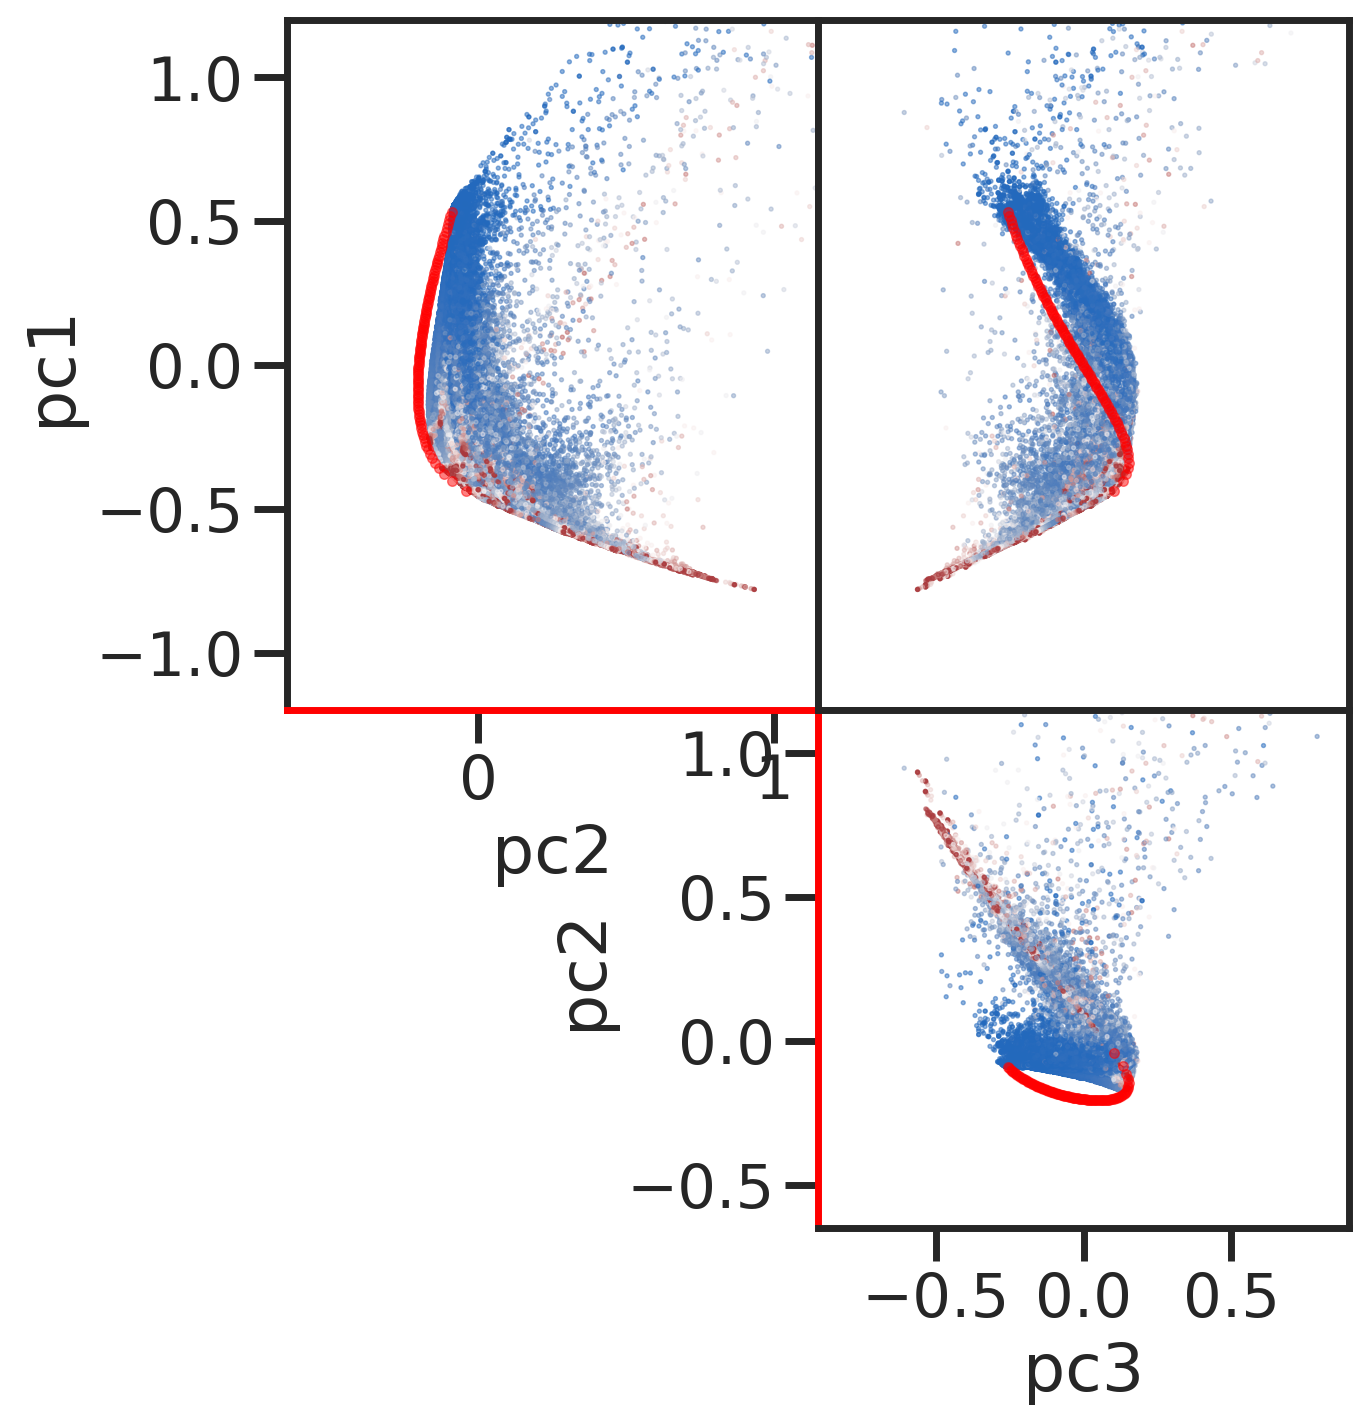

In [94]:
emph = [list(didx[didx.m=='geodesic'].index)]
f, gs = triplot(didx.reset_index(drop=True), r, emph=emph, d=3, cmap='vlag', ckey='t',
                grid_ratio=[4,3,3], grid_size=0.3,
                centers=[0,0.25,0])

In [95]:
f.savefig('plots/all_models_train_2d.pdf')  

#### Test with Geod (included in embedding)

In [96]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yvh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [59]:
p = r['xp'][-1, :]
u = np.linspace(-5, 5, 240)
v = np.linspace(0, 2 * np.pi, 240)
uGrid, vGrid = np.meshgrid(u, v)

x = uGrid * np.cos(vGrid) + p[0]
y = uGrid + p[1]
z = uGrid * np.sin(vGrid) + p[2]

surface = go.Surface(x=x, y=y, z=z, opacity=0.5)

In [ ]:
emph = list(didx[didx.m=='geodesic'].index)
cmap = {f"m: {c}": i for (i, c) in enumerate(didx.m.unique())} 
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    emph={'geodesic':emph, 'p0':emph[:1], 'p*':emph[-1:]},
                    empsize={'geodesic':4, 'p0':8, 'p*':8}, 
                    empcolor={'geodesic':'darkred', 'p0':'red', 'p*':'red'},
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='m',mode='markers', 
                    xrange=[-1, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [62]:
fig.write_image("plots/all_models_val_3d.pdf")

In [97]:
idxs = []
for (config, ii) in didx.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = didx.iloc[ii]['t'].max()
    didx.loc[ii, 't'] /= tmax
    if didx.iloc[ii[-1]]['err'] < 0.1:
        idxs.extend(ii)
# dd = didx.iloc[idxs].reset_index(drop=True)
# r['xp'] = r['xp'][idxs, :]

{'allcnn': 0, 'convmixer': 1, 'fc': 2, 'vit': 3, 'wr-10-4-8': 4, 'wr-16-4-64': 5}


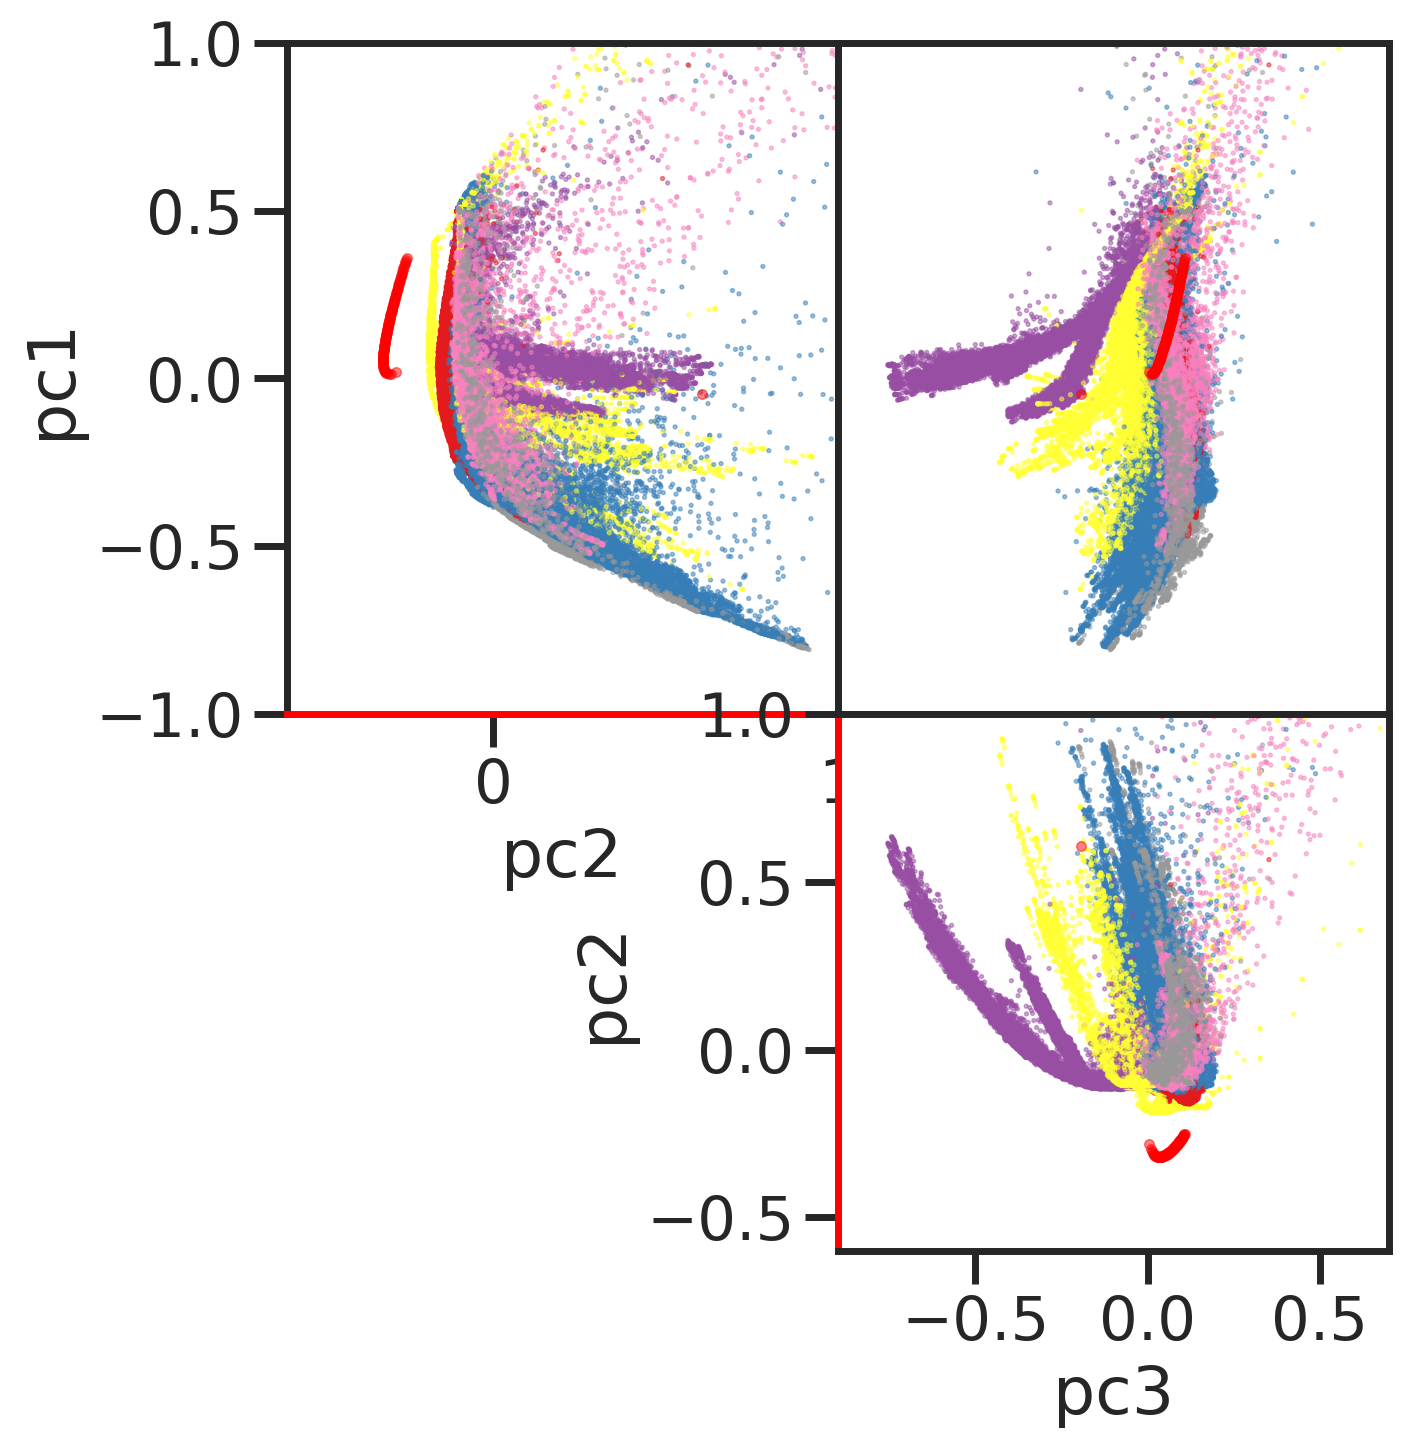

In [98]:
emph = [list(didx[didx.m=='geodesic'].index)]
f, gs = triplot(didx.reset_index(drop=True), r, emph=emph, d=3, cmap='Set1', ckey='m',
                grid_ratio=[5,4,4], grid_size=0.2, centers=[0, 0.2, -0.1])

In [99]:
f.savefig('plots/all_models_val_2d.pdf')  

### Reindexed Models

In [100]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/r_yh_all.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/didx_all.p").reset_index(drop=True)

In [8]:
import h5py
f = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/w_yh_all.h5', 'r')
w = f['w']

In [9]:
w.shape

(58500, 58500)

In [ ]:
from embed import proj_
l = np.eye(w.shape[0]) - 1.0/w.shape[0]
w = -l @ w @ l / 2
r = proj_(w, w.shape[0], 3)

In [31]:
r = th.load('/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/r_yh_all.h5')

In [ ]:
th.save(r, '/home/ubuntu/ext_vol/inpca/inpca_results_avg_new/r_yh_all.p')

In [ ]:
fig = plotly_3d(dc=didx.reset_index(drop=True), r=r, 
                    opacity=0.25,
                    colorscale='Set1',
                    ne=5, return_d=True,
                    color='m',mode='markers', 
                    xrange=[-0.75, 0.75],
                    yrange=[-0.75, 0.75],
                    zrange=[-0.75, 0.75])
# fig.add_trace(go.Surface(x=x, y=y, z=z, opacity=0.5))
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=-0.2, y=0, z=0),
    eye=dict(x=2.55, y=2.65, z=2.85)
)
fig.update_layout(scene_camera=camera)
fig.show()

In [102]:
fig.write_image("plots/interpolated_models_3d.pdf")

{'allcnn': 0, 'convmixer': 1, 'fc': 2, 'vit': 3, 'wr-10-4-8': 4, 'wr-16-4-64': 5}


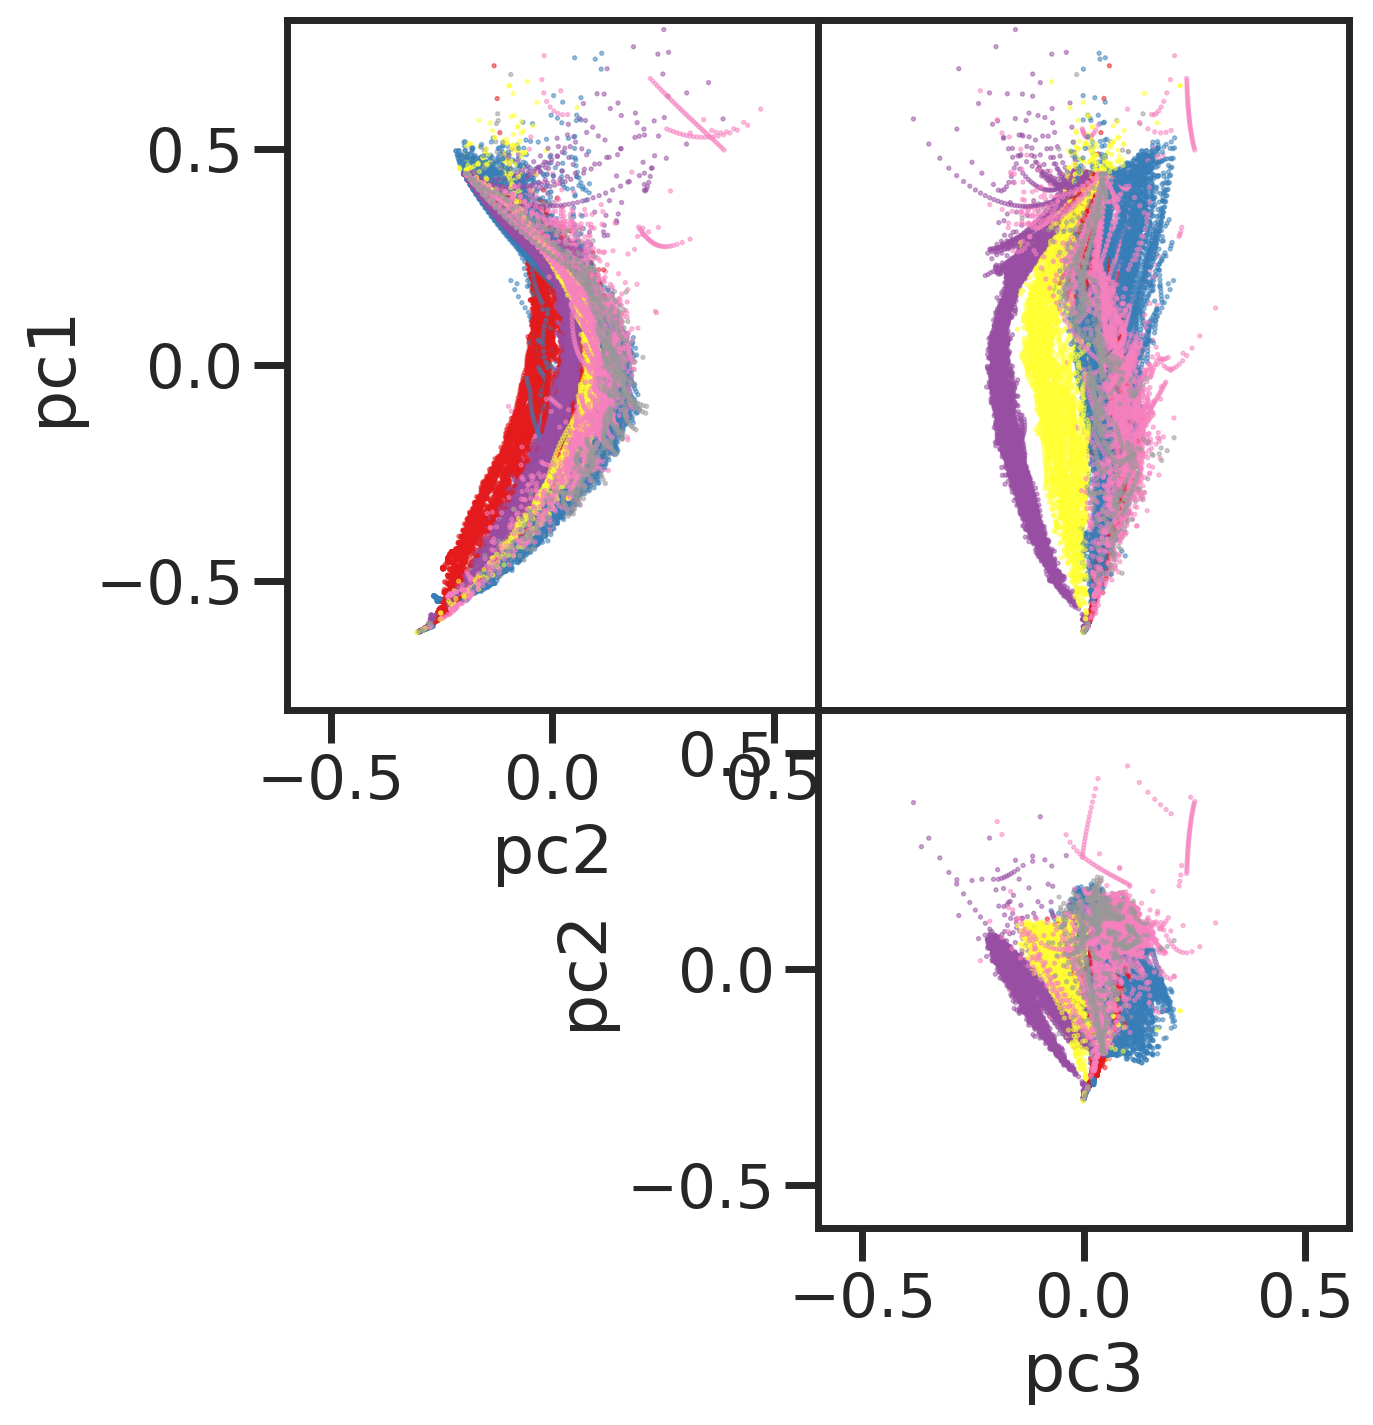

In [103]:
f, gs = triplot(didx.reset_index(drop=True), r, d=3, cmap='Set1', ckey='m',grid_ratio=[4,3,3], grid_size=0.2)

In [104]:
f.savefig('plots/interpolated_2d.pdf')  

#### Same models in original space

In [6]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_yh_all.p").reset_index(drop=True)

In [7]:
idxs = get_idx(didx, "aug=='none' & seed <=46")
dd = didx.iloc[idxs].reset_index(drop=True)

In [8]:
import h5py
from embed import proj_
f = h5py.File('/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all.h5', 'r')
w = f['w']
wi = w[idxs,:][:, idxs]
l = np.eye(wi.shape[0]) - 1.0/wi.shape[0]
wi = -l @ wi @ l / 2
r = proj_(wi, wi.shape[0], 3)

Projecting


In [9]:
th.save(r, "/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_interp_subset.p")

In [10]:
idxs = []
for (config, ii) in dd.groupby(['seed', 'm', 'opt', 'bs', 'aug', 'lr', 'wd']).indices.items():
    tmax = dd.iloc[ii]['t'].max()
    dd.loc[ii, 't'] /= tmax

{'allcnn': 0, 'convmixer': 1, 'fc': 2, 'vit': 3, 'wr-10-4-8': 4, 'wr-16-4-64': 5}


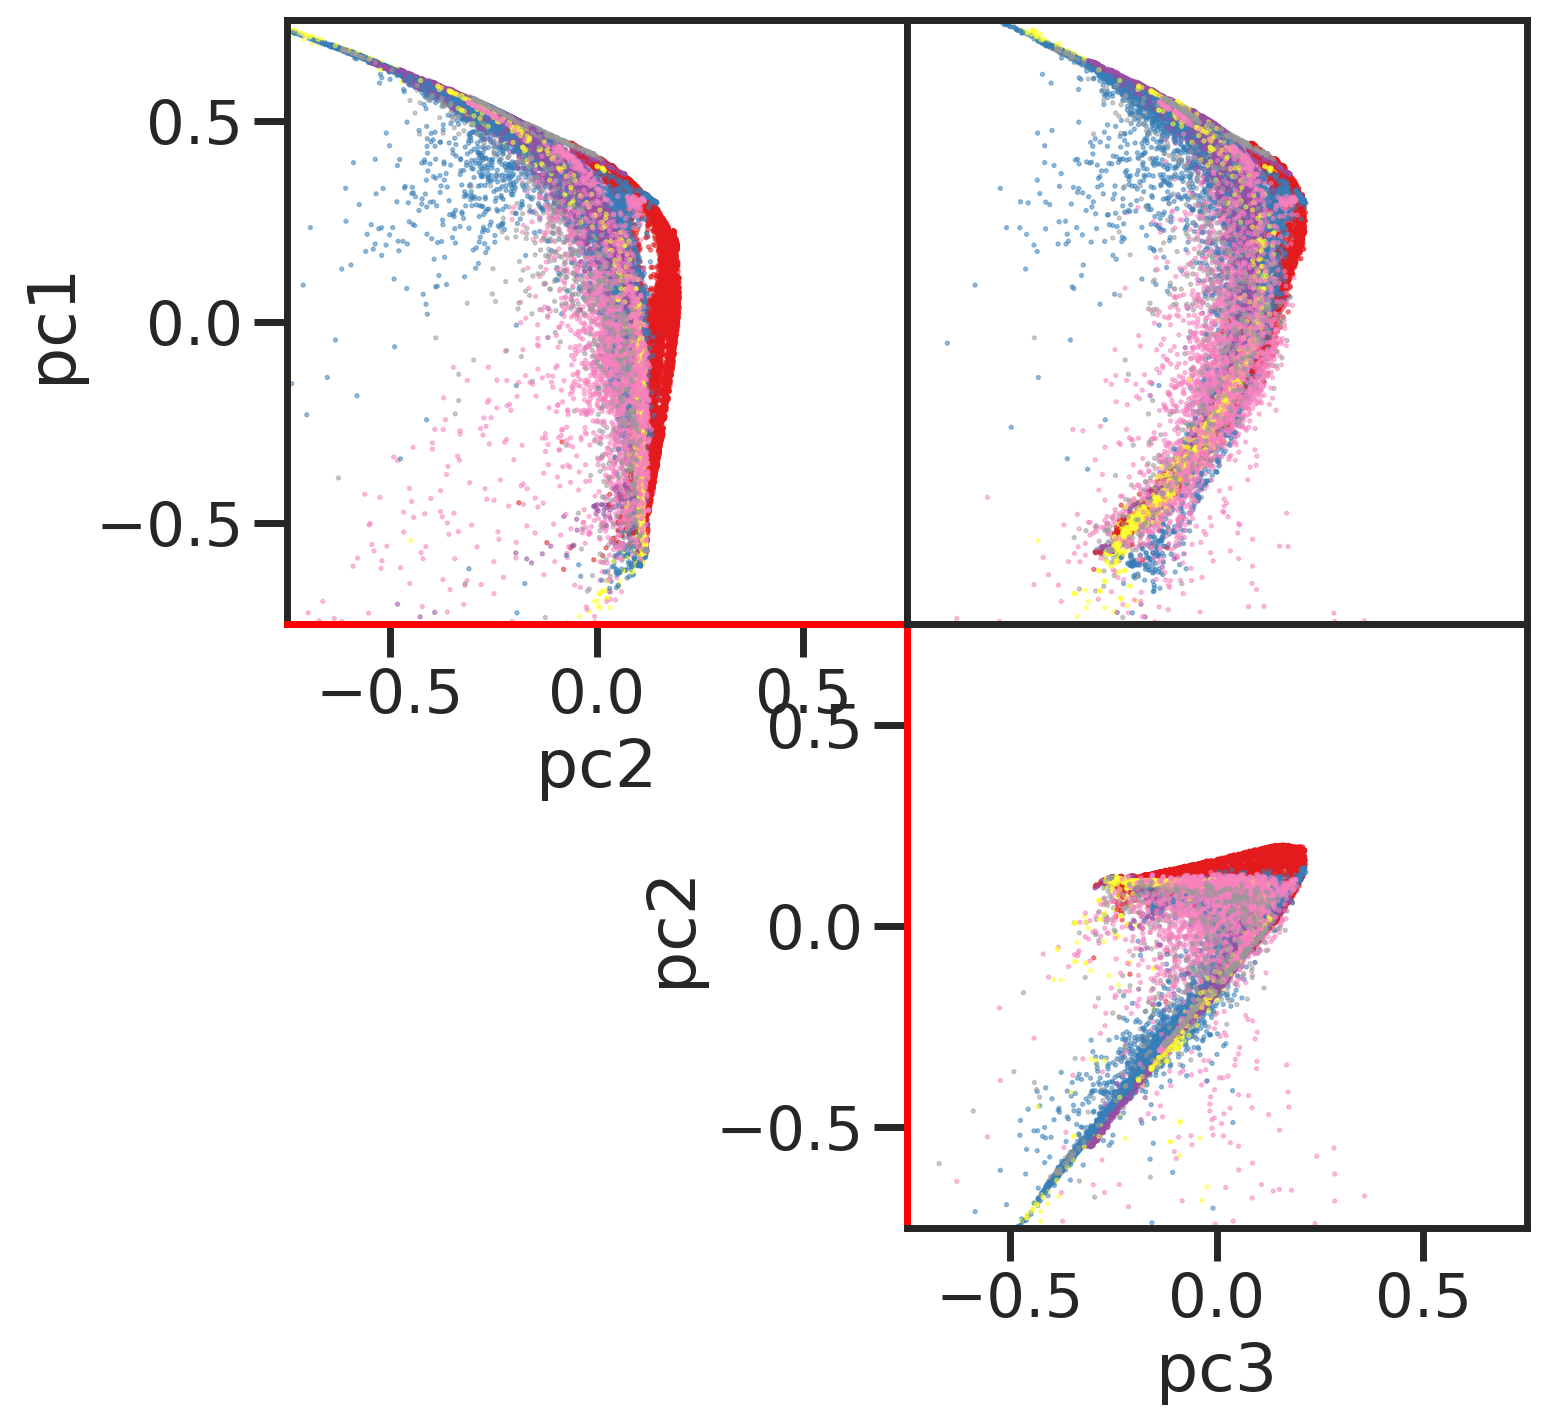

(<Figure size 1600x1600 with 3 Axes>, GridSpec(2, 2))

In [11]:
emph = get_idx(dd, "m=='geodesic'")
triplot(dd.reset_index(drop=True), r, emph=[emph], d=3, cmap='Set1', ckey='m',grid_ratio=[3,3,3], grid_size=0.25)

### MDS

In [143]:
r = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/r_yh_all_geod.p")
didx = th.load("/home/ubuntu/ext_vol/inpca/inpca_results_all/didx_geod_all.p").reset_index(drop=True)

In [144]:
idxs = get_idx(didx, "(m=='allcnn' and aug == 'simple' and wd==0.0) or m=='geodesic'")
didx = didx.iloc[idxs].reset_index(drop=True)
r['xp'] = r['xp'][idxs]

In [12]:
from sklearn.manifold import MDS
mds = MDS(n_components=3, metric=True, dissimilarity='precomputed')

In [135]:
import h5py
f = h5py.File(f'/home/ubuntu/ext_vol/inpca/inpca_results_all/w_yh_all_geod.h5', 'r')
w = f['w']

In [16]:
X_transformed = mds.fit_transform(w[idxs,:][:, idxs])
th.save(X_transformed, "mds_allcnn.p")

In [145]:
X_transformed = th.load('mds_allcnn.p')

In [146]:
r['xp'] = X_transformed

In [147]:
len(didx)

7878

In [ ]:
emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=didx, r=r, colorscale='Viridis', emph=emph, empsize=3,
                          ne=3, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-0.5, 0.5])
camera = dict(
    up=dict(x=1, y=0, z=0),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=1.25, z=1.25)
)

fig.update_layout(scene_camera=camera)
fig.show()

In [149]:
wi = w[idxs,:][:, idxs]
l = np.eye(wi.shape[0]) - 1.0/wi.shape[0]
wi = -l @ wi @ l / 2

In [150]:
from embed import proj_
r = proj_(wi, wi.shape[0], 3)

Projecting


In [ ]:
# emph = [list(didx[didx.m=='geodesic'].index)]
fig, text, dc = plotly_3d(dc=didx, r=r, colorscale='Viridis',  emph=emph, empsize=3,
                          ne=3, return_text=True, return_d=True,
              cols=['seed', 'm', 'opt', 'err', 'verr', 'bs', 'aug', 'bn', 'lr', 'wd'],
              color='t',mode='markers', cmap=None, separate_traj=False, axis_range=[-0.75, 0.75])
camera = dict(
    up=dict(x=0, y=0, z=1),
    center=dict(x=0, y=0, z=0),
    eye=dict(x=1.25, y=-1.25, z=1.25)
)

fig.update_layout(scene_camera=camera)
fig.show()